In [1]:
###############################################################################
# Author: Carlos Bobed
# Date: Nov 2020
# Comments: code to merge codetables, translate them and use them to compress
# Modifications:
###############################################################################

Now we have to merge different CTs and compare the compression rates

In [2]:
## method to read for the Vreeken's codetable format 
## we don't need it to be a generator 
## we do label each code and honor the order in the code table (length, support, lexicographical)
## following Pierre's suggestion, we keep track of the codes and the transaction IDs 
def read_codetable(filename, load_all): 
    codes = {}
    label = 0 
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        for line in file: 
            item_line = list(filter(None, line.rstrip('\n').split(' ')))
            ## only_used => those codes whose usage is > 0
            ## we get the last token, check whether it ends with )
            ## then, we get exactly the contents and check whether the first 
            ## component is different from 0
            if (item_line[-1].endswith(')')): 
                usage,support = item_line[-1][1:-1].split(',')
                if (load_all or int(usage) != 0):
                    codes[label]={'code': item_line[:-1], 'usage':int(usage), 'support':int(support)}
                    label+=1
    return codes    

## read information from the analysis to get back to the .dat file and select them
## we can cluster them according just to the items, or to the transactions themselves
## added the bidir table 
def read_analysis_table_bidir (filename): 
    db_dat_table = {}
    dat_db_table = {}
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        # skip the first  lines
        for i in range(15): 
            file.readline()
        current_line = file.readline()
        while (current_line != "\n"): 
            aux = current_line.split()[0].split('=>')
            db_dat_table[int(aux[0])] = int(aux[1])
            dat_db_table[int(aux[1])] = int(aux[0])
            current_line = file.readline()
    return db_dat_table, dat_db_table

def convert_int_codetable (codetable, analysis_table): 
    converted = {}
    for label in codetable: 
        translated_code = [ analysis_table[int(item)] for item in codetable[label]['code']]
        converted[label] = {'code_int':translated_code, 
                            'code_set':set(translated_code)}
    return converted

## for convenience we work here with integers (we kept the codetables as string tokens to be able to handle the vector models)
def merge_codetables (codetables): 
    merged = {}
    non_colision_labelbase = 0
    for ct in codetables: 
        for label in ct: 
            current_label = str(non_colision_labelbase) + '_' + str(label)
            merged[current_label] = ct[label]
        non_colision_labelbase +=1
    # we keep track of the codes that are duplicated
    to_omit = set() 
    merged_key_list = list(merged.keys())
    for i in range(len(merged_key_list)): 
        if merged_key_list[i] not in to_omit: 
            for j in range(i+1, len(merged_key_list)): 
                if merged_key_list[j] not in to_omit:
                    # depending on how the table has been obtained it might or not have the code_set field
                    ## converted using the analysis table (convert_int_codetable) => it has 
                    ## loaded from file => it hasn't 
                    if 'code_set' in merged[merged_key_list[i]]: 
                        set_i = merged[merged_key_list[i]]['code_set'] 
                    else:
                        set_i = set([int(item) for item in merged[merged_key_list[i]]['code']])
                    if 'code_set' in merged[merged_key_list[j]]: 
                        set_j = merged[merged_key_list[j]]['code_set']
                    else: 
                        set_j = set([int(item) for item in merged[merged_key_list[j]]['code']])
                    if set_i == set_j: 
                        to_omit.add(merged_key_list[j])
    # we get rid of the duplicated entries in the codetable
    [merged.pop(code) for code in to_omit]
     
    for label in merged: 
        if 'code_int' in merged[label]:
            merged[label]['code'] = [str(item) for item in merged[label]['code_int']]
        merged[label]['usage'] = 0
        merged[label]['support'] = 0
        
    return merged            


In [3]:
## to keep track of the transactions id in the database, we read them in a different method
def read_database_db (filename): 
    transactions = {}
    label = 0
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        for line in open(filename, mode='rt', encoding='UTF-8'): 
            if (line.split(':')[0].isnumeric()): 
                aux = line.split(':')[1].rstrip('\n')
                words = filter(None,aux.split(' '))
                transactions[label] = list(words)
                label+=1
    return transactions

def read_database_dat(filename): 
    transactions = {}
    label = 0
    with open(filename, mode='rt', encoding='UTF-8') as file: 
        for line in open(filename, mode='rt', encoding='UTF-8'): 
            aux = line.rstrip('\n')
            words = filter(None,aux.split(' '))
            transactions[label] = list(words)
            label+=1
    return transactions

In [4]:
# Standard cover order
# |X|↓ suppD(X) ↓ lexicographically ↑

# Standard candidate order 
# suppD(X) ↓|X|↓ lexicographically ↑   

def calculate_transaction_cover(transaction, codetable): 
    item_set = set(transaction)
    codes = []
    current_code = 0
    while (len(item_set) != 0 and current_code < len(codetable) ):
        aux_code_set = set(codetable[current_code]['code'])
        if (aux_code_set.issubset(item_set)): 
            codes.append(current_code)
            item_set.difference_update(aux_code_set)
        current_code+=1
    return codes

def calculate_codetable_support(database, codetable): 
    # to speed up the calculations, we augment the codetable with the set version of the code
    for label in codetable: 
        codetable[label]['code_set'] = set([int(item) for item in codetable[label]['code']])
    
    for trans in database: 
        item_set = set([int(item) for item in database[trans]])
        ## we have to check all the codes in the code table 
        ## this might be expensive ... we could just get the sum of the supports in the different databases 
        ## note that this is additive so in a better implementation it wouldn't be a problem
        for label in codetable: 
            ## if the intersection of the code is complete with the transaction
            if len(codetable[label]['code_set'].intersection(item_set)) == len(codetable[label]['code_set']): 
                codetable[label]['support'] += 1
        
## Note that I cannot do it until I have the codetable 
def calculate_codetable_usage (database, codetable): 
    for label in codetable: 
        codetable[label]['code_set'] = set([int(item) for item in codetable[label]['code']])
    
    for trans in database: 
        remaining_item_set = set([int(item) for item in database[trans]])
        current_code = 0
        while len(remaining_item_set) != 0 and current_code < len(codetable): 
            if len(codetable[current_code]['code_set'].intersection(remaining_item_set)) == len(codetable[current_code]['code_set']): 
                codetable[current_code]['usage'] += 1
                remaining_item_set = remaining_item_set - codetable[current_code]['code_set']
            current_code +=1
            
        if len(remaining_item_set) != 0: 
            print('This codetable is not covering properly the database ... is the SCT added?')


def codetable_in_standard_cover_order(codetable): 
    # we have to be careful with singleton codes (strings) ... if they have more than one char, they were 
    # getting innerly sorted
    return {idx:{'code':sorted(codetable[label]['code']) if not isinstance(codetable[label]['code'], str) else codetable[label]['code'], 
             'support':codetable[label]['support'], 
             'usage':codetable[label]['usage']}
                for idx,label in enumerate(sorted(codetable.keys(), reverse=True, 
                                                  key = lambda x:(len(codetable[x]['code']) if not isinstance(codetable[x]['code'],str) else 1
                                                                  ,codetable[x]['support'])), 
                                          start=0)}



In [5]:
def build_SCT(database): 
    sct_codetable = {}
    for trans in database: 
        for singleton in [int(item) for item in database[trans]]: 
            
            if singleton not in sct_codetable: 
                sct_codetable[singleton] = {'code':str(singleton), 'support':0, 'usage':0}
            sct_codetable[singleton]['usage'] = sct_codetable[singleton]['usage'] + 1
            sct_codetable[singleton]['support'] = sct_codetable[singleton]['support'] + 1
    return sct_codetable

In [6]:
import math
num_bits = - math.log(5/8,2)
num_bits

0.6780719051126377

In [7]:
import math
def calculate_size_database_from_codetable(codetable): 
    sum_usage = 0
    size = 0.0
    for label in codetable: 
        sum_usage += codetable[label]['usage']
    for label in codetable: 
        if (codetable[label]['usage'] != 0): 
            num_bits = -math.log(codetable[label]['usage'] / sum_usage)
            size += codetable[label]['usage'] * num_bits
    return size

In [8]:
# Driver Code 
A = {10, 20, 30, 40, 80} 
B = {100, 30, 80, 40, 60} 
A = A-B
print (A - B) 
print (B - A) 
print(A)

{10, 20}
{100, 40, 80, 60, 30}
{10, 20}


In [9]:
database_name = 'connect'
database_filename = database_name + '.db'
database_model_filename = database_filename + '.vect'
codetable_filename = database_name+'-latest-SLIM.ct'


In [62]:
import os
ct = read_codetable(os.path.join('databases', codetable_filename), False)
ct2 = read_codetable(os.path.join('databases', codetable_filename), True)
db = read_database_db(os.path.join('databases', database_filename))

In [63]:
merged = merge_codetables([ct,ct2])

In [64]:
print(len(merged))
print(len(ct))
print(len(ct2))

1799
1672
1799


In [65]:
calculate_codetable_support(db,merged)

merged

merged_std = codetable_in_standard_cover_order(merged)
merged_std

calculate_codetable_usage(db, merged_std)

ct2

merged_std

In [ ]:
# I still have to: 
# - build a non initialized singleton codetable 
# - calculate the size of the database from usages
# - calculate the ratio of the database compressed with the codetable, and the database compressed with the SCT. 


sct = build_SCT(db)

sct

sct_std = codetable_in_standard_cover_order(sct)

sct_std

In [20]:
merged_size = calculate_size_database_from_codetable (merged_std)
sct_size = calculate_size_database_from_codetable(sct_std)

NameError: name 'merged_std' is not defined

In [175]:
print(f'merged_size:{merged_size} sct_size:{sct_size} ratio:{merged_size/sct_size}')

merged_size:756.0819697876997 sct_size:2119.9251812539783 ratio:0.35665502559881007


In [12]:
import os
## testing everything together (connect database)

database_name = 'connect'
database_db_filename = database_name + '.db'
database_dat_filename = database_name + '.dat'
database_model_filename = database_filename + '.vect'
database_analysis_filename = database_db_filename + '.analysis.txt'
codetable_filename = database_name+'-latest-SLIM.ct'

In [13]:
db_dat_table, dat_db_table = read_analysis_table_bidir(os.path.join('databases', database_analysis_filename))

In [14]:
## we calculate the compression rate in the .dat 
orig_codetable = read_codetable(os.path.join('databases', codetable_filename), True)
converted_orig_codetable = convert_int_codetable(orig_codetable, db_dat_table)
orig_dat_database = read_database_dat(os.path.join('databases', database_dat_filename))

In [15]:
print(len(converted_orig_codetable))
print(converted_orig_codetable[0])
print(orig_codetable[0])

1799
{'code_int': [91, 109, 127, 75, 55, 37, 19, 88, 106, 124, 72, 85, 16, 121, 82, 13, 118, 79, 10, 115, 1, 7, 76, 112, 4], 'code_set': {1, 4, 7, 10, 13, 16, 19, 37, 55, 72, 75, 76, 79, 82, 85, 88, 91, 106, 109, 112, 115, 118, 121, 124, 127}}
{'code': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '16', '18', '19', '23', '25', '26', '30', '32', '33', '35', '39', '42'], 'usage': 2404, 'support': 2404}


In [16]:
converted_orig_codetable = merge_codetables([converted_orig_codetable])
calculate_codetable_support(orig_dat_database, converted_orig_codetable)
converted_orig_codetable_sco = codetable_in_standard_cover_order(converted_orig_codetable)

In [17]:
print(len(converted_orig_codetable))
print(converted_orig_codetable['0_1'])
print(converted_orig_codetable_sco[0])

1799
{'code_int': [91, 109, 127, 75, 55, 37, 19, 88, 106, 124, 72, 85, 16, 121, 82, 13, 118, 79, 10, 115, 1, 7, 76, 4, 113], 'code_set': {1, 4, 7, 10, 13, 16, 19, 37, 55, 72, 75, 76, 79, 82, 85, 88, 91, 106, 109, 113, 115, 118, 121, 124, 127}, 'code': ['91', '109', '127', '75', '55', '37', '19', '88', '106', '124', '72', '85', '16', '121', '82', '13', '118', '79', '10', '115', '1', '7', '76', '4', '113'], 'usage': 0, 'support': 1363}
{'code': ['1', '10', '106', '109', '112', '115', '118', '121', '124', '127', '13', '16', '19', '37', '4', '55', '7', '72', '75', '76', '79', '82', '85', '88', '91'], 'support': 2404, 'usage': 0}


In [18]:
calculate_codetable_usage(orig_dat_database, converted_orig_codetable_sco)

In [19]:
sct_codetable = build_SCT(orig_dat_database)
sct_codetable_sco = codetable_in_standard_cover_order(sct_codetable)

In [20]:
orig_size = calculate_size_database_from_codetable (converted_orig_codetable_sco)
sct_size = calculate_size_database_from_codetable(sct_codetable_sco)
orig_ratio = orig_size / sct_size 
print(f'orig_ratio:{orig_ratio}')

orig_ratio:0.11404116846703768


In [60]:
orig_usage_array = [converted_orig_codetable_sco[i]['usage'] for i in converted_orig_codetable_sco]
orig_support_array = [converted_orig_codetable_sco[i]['support'] for i in converted_orig_codetable_sco]
orig_length_codes_array=[len(converted_orig_codetable_sco[i]['code']) for i in converted_orig_codetable_sco]

sct_usage_array = [sct_codetable_sco[i]['support'] for i in sct_codetable_sco]

In [26]:
print(len(set(orig_usage_array)))
print(len(set(orig_support_array)))
print(len(set(sct_usage_array)))

381
693
124


In [ ]:
# we draw the histogram of the usage of the codes as well as the histogram of their support 
## as well as the histogram of the support of the items 

# again kudos for making things easier to 

# https://datatofish.com/plot-histogram-python/
# n = number of observations
# Range = maximum value – minimum value
# # of intervals =  √n
# Width of intervals =  Range / (# of intervals)

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.hist(orig_usage_array, bins=100, range=[0, max(orig_usage_array)])
plt.title('Orig codetable Usage')
plt.show()

plt.hist(orig_support_array, bins=100, range=[0, max(orig_support_array)])
plt.title('Orig codetable Support')
plt.show()

plt.hist(orig_length_codes_array, bins=100, range=[0, max(orig_length_codes_array)])
plt.title('Orig length codes')
plt.show()

plt.hist(sct_usage_array, bins=100, range=[0, max(sct_usage_array)])
plt.title('Item codetable Support')
plt.show()



0.11399764858298939161 is the ratio of the original calculation (Vreekens' report file || dbSize columns) 

In [43]:
# Now the different codetables calculated each separately
# connect_trans_clust_i.ct
# connect_trans_clust_i.db.analysis.txt

codetables = []
for i in range(8): 
#     current_name = database_name+'_trans_clust_'+str(i)+'_k4'
    current_name = database_name+'_trans_clust_'+str(i)
    aux_db_dat_table, aux_dat_db_table = read_analysis_table_bidir(os.path.join('databases', current_name+'.db.analysis.txt'))
#     aux_codetable = read_codetable(os.path.join('databases', database_name+'_trans_clust_'+str(i)+'_k4.ct'), True)
    aux_codetable = read_codetable(os.path.join('databases', database_name+'_trans_clust_'+str(i)+'.ct'), True)
    aux_converted_codetable = convert_int_codetable(aux_codetable, aux_db_dat_table)
    codetables.append(aux_converted_codetable)


In [44]:
codetables

[{0: {'code_int': [127,
    124,
    121,
    91,
    88,
    85,
    75,
    72,
    55,
    52,
    37,
    34,
    19,
    16,
    13,
    31,
    69,
    82,
    49,
    109,
    66,
    79,
    63,
    76,
    1,
    44,
    60,
    24,
    42],
   'code_set': {1,
    13,
    16,
    19,
    24,
    31,
    34,
    37,
    42,
    44,
    49,
    52,
    55,
    60,
    63,
    66,
    69,
    72,
    75,
    76,
    79,
    82,
    85,
    88,
    91,
    109,
    121,
    124,
    127}},
  1: {'code_int': [127,
    124,
    121,
    91,
    88,
    85,
    75,
    72,
    55,
    52,
    37,
    34,
    19,
    16,
    13,
    31,
    69,
    82,
    49,
    109,
    66,
    79,
    63,
    76,
    1,
    44,
    23,
    42,
    58],
   'code_set': {1,
    13,
    16,
    19,
    23,
    31,
    34,
    37,
    42,
    44,
    49,
    52,
    55,
    58,
    63,
    66,
    69,
    72,
    75,
    76,
    79,
    82,
    85,
    88,
    91,
    109,
    121,
    124,
    127}},


In [45]:
orig_dat_database = read_database_dat(os.path.join('databases', database_dat_filename))

converted_merged_codetable = merge_codetables(codetables)


In [46]:
print([len(ct) for ct in codetables])
print(sum([len(ct) for ct in codetables]))
print(len(converted_merged_codetable))


[506, 476, 552, 512, 633, 544, 575, 532]
4330
3651


In [47]:
calculate_codetable_support(orig_dat_database, converted_merged_codetable)
converted_merged_codetable_sco = codetable_in_standard_cover_order(converted_merged_codetable)


In [48]:
calculate_codetable_usage(orig_dat_database, converted_merged_codetable_sco)

In [49]:
sct_codetable = build_SCT(orig_dat_database)
sct_codetable_sco = codetable_in_standard_cover_order(sct_codetable)

In [50]:
merged_size = calculate_size_database_from_codetable (converted_merged_codetable_sco)
sct_size = calculate_size_database_from_codetable(sct_codetable_sco)
merged_ratio = merged_size / sct_size 
print(f'merged_ratio:{merged_ratio}')

merged_ratio:0.16675686948434545


In [51]:
converted_merged_codetable_sco[0]

{'code': ['1',
  '10',
  '100',
  '103',
  '106',
  '109',
  '118',
  '121',
  '124',
  '127',
  '13',
  '16',
  '19',
  '23',
  '25',
  '28',
  '31',
  '34',
  '37',
  '40',
  '46',
  '49',
  '52',
  '55',
  '59',
  '66',
  '69',
  '72',
  '75',
  '76',
  '79',
  '82',
  '85',
  '88',
  '91'],
 'support': 161,
 'usage': 161,
 'code_set': {1,
  10,
  13,
  16,
  19,
  23,
  25,
  28,
  31,
  34,
  37,
  40,
  46,
  49,
  52,
  55,
  59,
  66,
  69,
  72,
  75,
  76,
  79,
  82,
  85,
  88,
  91,
  100,
  103,
  106,
  109,
  118,
  121,
  124,
  127}}

In [57]:
print(len(converted_merged_codetable_sco))
print(len({label:converted_merged_codetable_sco[label] for label in converted_merged_codetable_sco if converted_merged_codetable_sco[label]['usage']>0}))
print(len({label:converted_merged_codetable_sco[label] for label in converted_merged_codetable_sco if converted_merged_codetable_sco[label]['usage']>10}))

3651
3487
2934


In [58]:
merged_usage_array = [converted_merged_codetable_sco[i]['usage'] for i in converted_merged_codetable_sco]
merged_support_array = [converted_merged_codetable_sco[i]['support'] for i in converted_merged_codetable_sco]
merged_length_array = [len(converted_merged_codetable_sco[i]['code']) for i in converted_merged_codetable_sco]

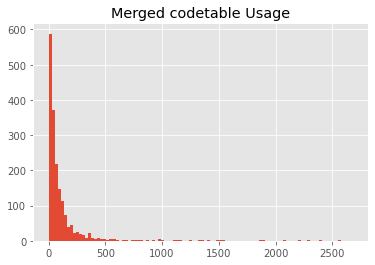

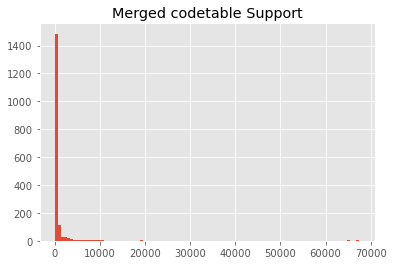

In [59]:
# we draw the histogram of the usage of the codes as well as the histogram of their support 
## as well as the histogram of the support of the items 

# again kudos for making things easier to 

# https://datatofish.com/plot-histogram-python/
# n = number of observations
# Range = maximum value – minimum value
# # of intervals =  √n
# Width of intervals =  Range / (# of intervals)

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.hist(orig_usage_array, bins=100, range=[0, max(merged_usage_array)])
plt.title('Merged codetable Usage')
plt.show()

plt.hist(orig_support_array, bins=100, range=[0, max(merged_support_array)])
plt.title('Merged codetable Support')
plt.show()

plt.hist(merged_length_array, bins=100, range=[0, max(merged_length_array)])
plt.title('Merged codetable lengths')
plt.show()
